In [14]:
import numpy as np
import os
import trimesh
from trimesh.sample import sample_surface_sphere
from shapely.geometry import LineString
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_DIR = '../../../../data/ShapeNetCorev2/ShapeNetCore.v2/'
synsetId = '02691156'
modelId = '5b985bc192961c595de04aad18bd94c3'

MODEL_DIR = os.path.join(DATA_DIR, synsetId, modelId, 'models')
STATS = os.path.join(MODEL_DIR, 'model_normalized.json')
MESH = os.path.join(MODEL_DIR, 'model_normalized.obj')
MATERIALS = os.path.join(MODEL_DIR, 'model_normalized.mtl')
FULL_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.solid.binvox')
SURF_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.surface.binvox')

In [3]:
mesh = trimesh.load_mesh(MESH)

# Basic features

In [6]:
# is the current mesh watertight?
mesh.is_watertight

False

In [11]:
# what's the euler number for the mesh?
mesh.euler_number

1404

In [8]:
# the convex hull is another Trimesh object that is available as a property
# lets compare the volume of our mesh with the volume of its convex hull
np.divide(mesh.volume, mesh.convex_hull.volume)

3.610451951692329e-18

In [9]:
# what's the moment of inertia for the mesh?
mesh.moment_inertia

array([[-7.19978005e-21, -1.26834361e-22,  1.38348715e-21],
       [-1.26834361e-22, -7.42918481e-21, -4.51750905e-22],
       [ 1.38348715e-21, -4.51750905e-22, -1.72935893e-22]])

In [10]:
# if there are multiple bodies in the mesh we can split the mesh by
# connected components of face adjacency
# since this example mesh is a single watertight body we get a list of one mesh
mesh.split()

[]

In [12]:
# preview mesh in a pyglet window from a terminal, or inline in a notebook
mesh.show()

In [13]:
mesh.convex_hull.show()

In [16]:
mesh.bounding_box_oriented.show()

In [18]:
mesh.bounding_cylinder.show()

In [19]:
mesh.bounding_sphere.show()

# Planar slices

In [21]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[0,0,1])

In [22]:
# the section will be in the original mesh frame
slice.show()

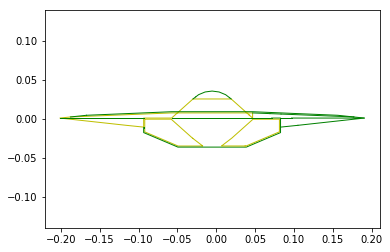

In [23]:
# we can move the 3D curve to a Path2D object easily
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

In [36]:
# if we wanted to take a bunch of parallel slices, like for a 3D printer
# we can do that easily with the section_multiplane method
# we're going to slice the mesh into evenly spaced chunks along z
# this takes the (2,3) bounding box and slices it into [minz, maxz]
z_extents = mesh.bounds[:,2]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=.100)

In [37]:
# find a bunch of parallel cross sections
sections = mesh.section_multiplane(plane_origin=mesh.bounds[0], 
                                   plane_normal=[0,0,1], 
                                   heights=z_levels)
sections

[None,
 None,
 None,
 None,
 None,
 None,

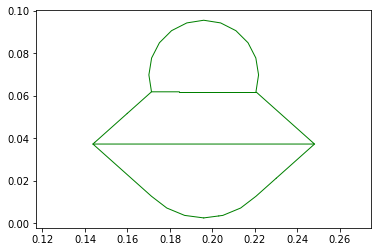

In [31]:
# summing the array of Path2D objects will put all of the curves
# into one Path2D object, which we can plot easily
combined = np.sum(sections[-1:])
combined.show()

In [39]:
mesh.bounds

array([[-0.196143, -0.044349, -0.549598],
       [ 0.195624,  0.103242,  0.341385]])

# Sampling and signed distance

In [4]:
# we can sample the volume of Box primitives
points = mesh.bounding_box_oriented.sample_volume(count=10)

In [5]:
# find the closest point on the mesh to each random point
(closest_points,
 distances,
 triangle_id) = mesh.nearest.on_surface(points)
print('Distance from point to surface of mesh:\n{}'.format(distances))

Distance from point to surface of mesh:
[0.06715399 0.05832153 0.07215251 0.01855287 0.00038767 0.048698
 0.05957496 0.01905514 0.03408119 0.02082137]


In [6]:
# create a PointCloud object out of each (n,3) list of points
cloud_original = trimesh.points.PointCloud(points)
cloud_close    = trimesh.points.PointCloud(closest_points)

# create a unique color for each point
cloud_colors = np.array([trimesh.visual.random_color() for i in points])

# set the colors on the random point and its nearest point to be the same
cloud_original.vertices_color = cloud_colors
cloud_close.vertices_color    = cloud_colors

# create a scene containing the mesh and two sets of points
scene = trimesh.Scene([mesh,
                       cloud_original,
                       cloud_close])

# show the scene wusing 
scene.show()